### Import des librairies

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import numpy as np
import random
import joblib
from keras.utils import to_categorical
from sklearn import preprocessing
import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Connexion au drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Récupération des datas et préparation du jeu de données

### Préparation du jeu de données

In [30]:
# Chemin vers le dossier principal contenant les sous-dossiers

main_folder = '/content/drive/MyDrive/Detection_yeux/MMU-Iris-Database'
local_folder = "../data/"

In [31]:
def get_data_labels(main_folder, side_eye):

  """Fais un jeu de données sur MMU-Iris-Database avec en target "left" ou "right" """

  X = []
  y = []

  for target_folder in tqdm.tqdm(os.listdir(main_folder)):
    personnal_number_path = os.path.join(main_folder, target_folder)
    # chemin/42 etc
    if os.path.isdir(personnal_number_path):
      side_eye_path = os.path.join(personnal_number_path, side_eye)
      for eye_photo in os.listdir(side_eye_path): # Pour dossier dans dossier_gauche... (gauche)
        if eye_photo.lower().endswith(('.bmp', '.jpg', '.png')):
            image_path = os.path.join(side_eye_path, eye_photo)
            target = int(target_folder) # target = gauche ou droite
            image = cv2.imread(image_path)
            X.append(image)
            y.append(target)
  return X, y

X, y = get_data_labels(local_folder, "left")

100%|██████████| 47/47 [00:00<00:00, 72.51it/s]


### Enregistrement du jeu de données sur drive

In [ ]:
!pwd

In [14]:
# Copie les variables d'entrée et de sortie sur drive pour pouvoir les charger plus rapidement à la relance du notebook

joblib.dump(X_train_augmented, "../variables/oeil_gauche/augmented/X_train_augmented")
joblib.dump(y_train_augmented, "../variables/oeil_gauche/augmented/y_train_augmented")
joblib.dump(X_val_augmented, "../variables/oeil_gauche/augmented/X_val_augmented")
joblib.dump(y_val_augmented, "../variables/oeil_gauche/augmented/y_val_augmented")
joblib.dump(X_test_augmented, "../variables/oeil_gauche/augmented/X_test_augmented")
joblib.dump(y_test_augmented, "../variables/oeil_gauche/augmented/y_test_augmented")
# ! cp variables/X /content/drive/MyDrive/Detection_yeux/variables/oeil_gauche/X
# ! cp variables/y /content/drive/MyDrive/Detection_yeux/variables/oeil_gauche/y

['../variables/oeil_gauche/augmented/y_test_augmented']

### Chargement du jeu de données

In [8]:
# X, y = joblib.load("/content/drive/MyDrive/Detection_yeux/variables/oeil_gauche/X"), joblib.load("/content/drive/MyDrive/Detection_yeux/variables/oeil_gauche/y")

# En local
X = joblib.load(r"../variables/oeil_gauche/X")
y = joblib.load(r"../variables/oeil_gauche/y")

# Ces variables sont deja label encodées
# X_train_augmented = joblib.load(r"../variables/oeil_gauche/augmented/X_train_augmented")
# y_train_augmented = joblib.load(r"../variables/oeil_gauche/augmented/y_train_augmented")
# X_val_augmented = joblib.load(r"../variables/oeil_gauche/augmented/X_val_augmented")
# y_val_augmented = joblib.load(r"../variables/oeil_gauche/augmented/y_val_augmented")
# X_test_augmented = joblib.load(r"../variables/oeil_gauche/augmented/X_test_augmented")
# y_test_augmented = joblib.load(r"../variables/oeil_gauche/augmented/y_test_augmented")

## Séparation en jeu d'entraînement, validation et test

In [9]:
# labelenc = LabelEncoder()
# y_enc = labelenc.fit_transform(y)

In [5]:
# joblib.dump(labelenc, "../variables/oeil_gauche/labelenc")

['../variables/oeil_gauche/labelenc']

In [10]:
X_train, X_int, y_train, y_int = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_int, y_int, test_size = 0.5, random_state = 42, stratify = y_int)

## Data augmentation

In [11]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [12]:
datagen = ImageDataGenerator(
    rotation_range=15,
    height_shift_range=0.2,
    width_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
)

def augment_images(side_eye, data_usage, image_pool, image_labels, number_augmented_images_per_images):
    """- side_eye must be right or left, image_pool like X_train and image_labels like y_train"""
    """- data_usage must be train, val or test"""
    for image, label in zip(image_pool, image_labels):
        save_to_dir = f"../data/augmented/{side_eye}/{label}/{data_usage}"
        if not os.path.exists(save_to_dir):
            os.makedirs(save_to_dir) 
        image = image.reshape((1,) + image.shape)
        i = 0
        for batch in datagen.flow(image, batch_size=1, save_to_dir=save_to_dir):
            i += 1 
            if i > number_augmented_images_per_images:
                break

augment_images("left", "train", X_test, y_test, 5)
augment_images("left", "val", X_val, y_val, 5)
augment_images("left", "test", X_test, y_test, 5)

In [13]:
def get_augmented_images(folder, data_usage):
    """- For data_usage pick either train, val or test
    - Folder type "..\data\augmented\left" (le côté oeil est dans le nom fichier)"""
    # def get_data_labels(main_folder, side_eye):

    X = []
    y = []

    for target_folder in tqdm.tqdm(os.listdir(folder)):
        personnal_number_path = os.path.join(folder, target_folder)
        # chemin/42 etc
        if os.path.isdir(personnal_number_path):
            data_usage_path = os.path.join(personnal_number_path, data_usage)
            for eye_photo in os.listdir(data_usage_path): # Pour dossier dans dossier_gauche... (gauche)
                if eye_photo.lower().endswith(('.bmp', '.jpg', '.png')):
                    image_path = os.path.join(data_usage_path, eye_photo)
                    target = int(target_folder)
                    image = cv2.imread(image_path)
                    X.append(image)
                    y.append(target)
    return X, y

X_train_augmented, y_train_augmented = get_augmented_images(r"..\data\augmented\left", "train")
X_val_augmented, y_val_augmented = get_augmented_images(r"..\data\augmented\left", "val")
X_test_augmented, y_test_augmented = get_augmented_images(r"..\data\augmented\left", "test")

100%|██████████| 45/45 [00:01<00:00, 27.40it/s]


In [6]:
IMG_SIZE = [240, 320]

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
  image = (image / 255.0)
  return image, label

def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE[0], IMG_SIZE[1], 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

## Aperçu et vérification du jeu de donnée

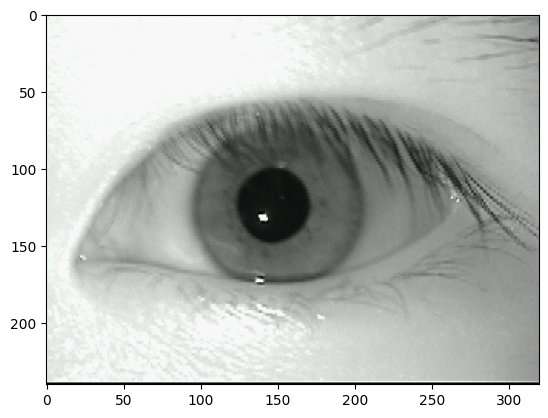

1


In [18]:
plt.imshow(X_train[25,:])
plt.show()
print(y_train[25])

## Prétraitement des données

In [22]:
labelenc = joblib.load(r"..\variables\oeil_gauche\labelenc")
y_train_augmented_enc = labelenc.transform(y_train_augmented)
y_val_augmented_enc = labelenc.transform(y_val_augmented)
y_test_augmented_enc = labelenc.transform(y_test_augmented)

In [23]:
y_train_augmented_cat, y_val_augmented_cat, y_test_agumented_cat = to_categorical(y_train_augmented_enc), to_categorical(y_val_augmented_enc), to_categorical(y_test_augmented_enc)

## Définition des modèles à tester

In [4]:
NBCLASSES = 45
IMSIZE=(240, 320, 3)

In [5]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

### Model 1

In [ ]:
# Chargement du modèle
vgg = VGG16(input_shape = IMSIZE, weights = 'imagenet', include_top = False)

# Freeze existing som VGG layers (before two lasts)
for layer in vgg.layers[:-2]:
    layer.trainable = False


model1 = tf.keras.Sequential([
  # Réajustement de la dimension de l'image
  layers.Resizing(IMSIZE[0], IMSIZE[1], crop_to_aspect_ratio=True),
  # Normalisation des pixels
  layers.Rescaling(1./255, input_shape=IMSIZE),
  # Ajout des couches VGG16
  vgg,
  # Ajout d'une couche de neurones
  # Conv2D(32, (3, 3), activation="relu", input_shape=IMSIZE),
  # MaxPooling2D((2, 2)),
  # Conv2D(32, (3, 3), activation="relu"),
  # MaxPooling2D((2, 2)),
  Flatten(),
  Dense(NBCLASSES, activation="softmax")
  ], name="left_side_classifier")


model1.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

# Montrer l'architecture du modèle et le nombre de paramètres entrainables
model1.build(input_shape=((None,) + IMSIZE))
model1.summary()

### Model 2

In [ ]:
# Même modèle mais avecsoftmax
# Chargement du modèle
vgg = VGG16(input_shape = IMSIZE, weights = 'imagenet', include_top = False)

# Freeze existing som VGG layers (before two lasts)
for layer in vgg.layers[:-2]:
    layer.trainable = False


model2 = tf.keras.Sequential([
  # Réajustement de la dimension de l'image
  layers.Resizing(IMSIZE[0], IMSIZE[1], crop_to_aspect_ratio=True),
  # Normalisation des pixels
  layers.Rescaling(1./255, input_shape=IMSIZE),
  # Ajout des couches VGG16
  vgg,
  # Ajout d'une couche de neurones
  # Conv2D(32, (3, 3), activation="relu", input_shape=IMSIZE),
  # MaxPooling2D((2, 2)),
  # Conv2D(32, (3, 3), activation="relu"),
  # MaxPooling2D((2, 2)),
  Flatten(),
  Dense(45, activation="softmax")
  ], name="model2")


model2.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

# Montrer l'architecture du modèle et le nombre de paramètres entrainables
model2.build(input_shape=((None,) + IMSIZE))
model2.summary()

### Modèle début

In [28]:
liste=  [1,2,3,4,5]
liste[:-2]

[1, 2, 3]

In [31]:
def create_model():
  
  # Chargement du modèle
  vgg = VGG16(input_shape = IMSIZE, weights = 'imagenet', include_top = False)

  # Freeze existing som VGG layers (before two lasts)
  for layer in vgg.layers:
      layer.trainable = True
  


  modele_debut = tf.keras.Sequential([
    # Réajustement de la dimension de l'image
    layers.Resizing(IMSIZE[0], IMSIZE[1], crop_to_aspect_ratio=True),
    # Normalisation des pixels
    layers.Rescaling(1./255, input_shape=IMSIZE),
    # Ajout des couches VGG16
    vgg,
    # Ajout d'une couche de neurones
    # Conv2D(32, (3, 3), activation="relu", padding="same"),
    Flatten(),
    Dense(NBCLASSES, activation="softmax")
    ], name="model3")
    
  modele_debut.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])

  # Montrer l'architecture du modèle et le nombre de paramètres entrainables
  modele_debut.build(input_shape=((None,) + IMSIZE))
  modele_debut.summary()

  return modele_debut


 
OG_model = create_model()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 240, 320, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 240, 320, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 10, 512)        14714688  
                                                                 
 flatten_3 (Flatten)         (None, 35840)             0         
                                                                 
 dense_3 (Dense)             (None, 45)                1612845   
                                                                 
Total params: 16327533 (62.28 MB)
Trainable params: 16327533 (62.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entraînement

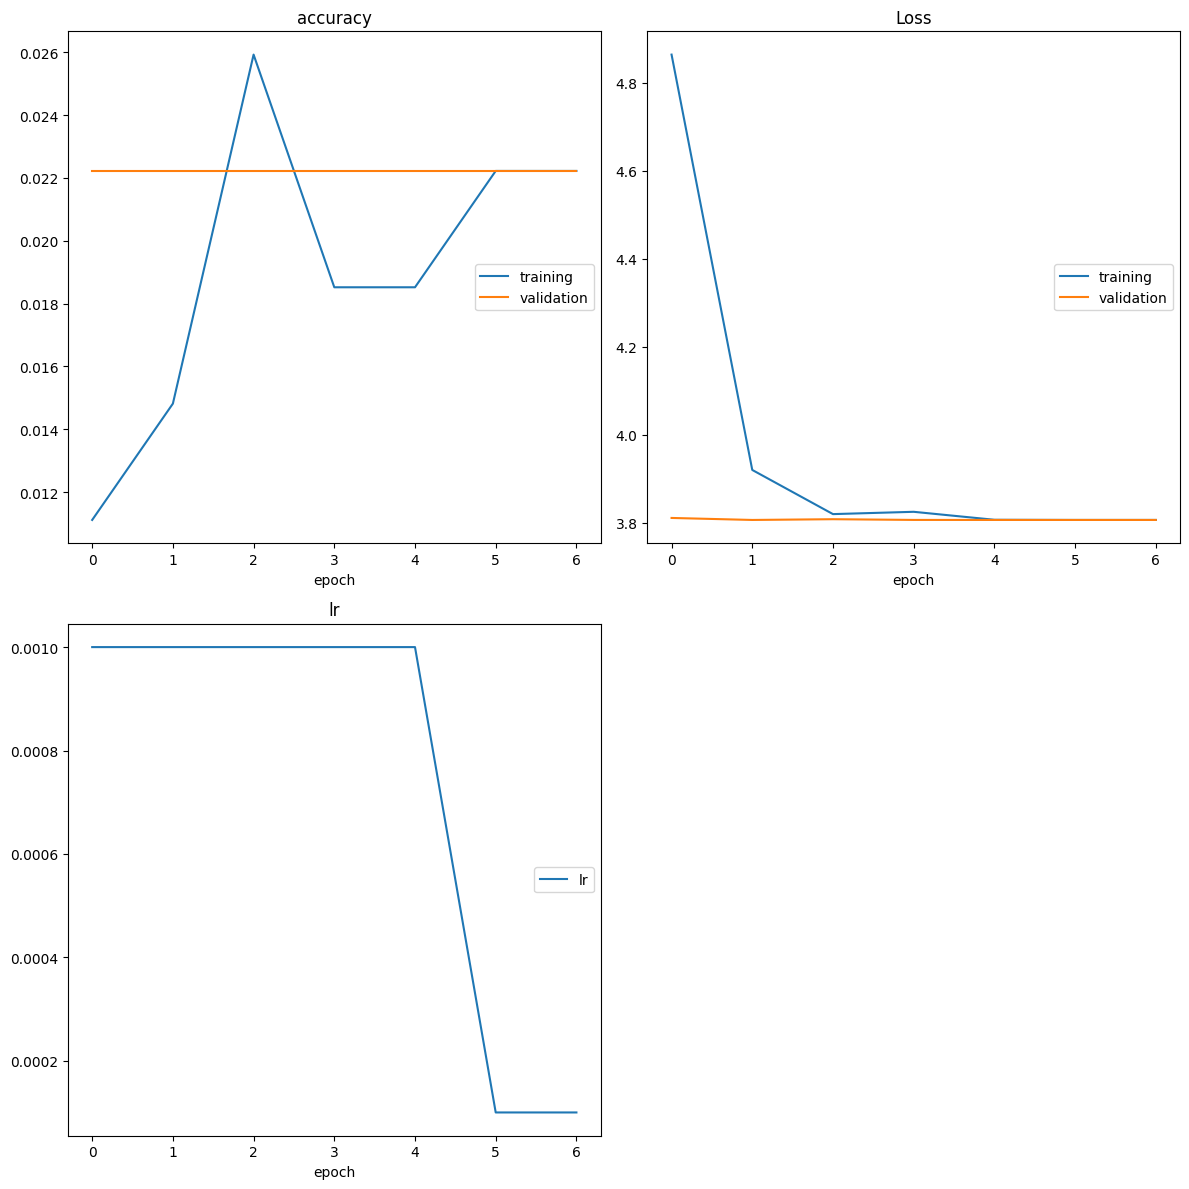

accuracy
	training         	 (min:    0.011, max:    0.026, cur:    0.022)
	validation       	 (min:    0.022, max:    0.022, cur:    0.022)
Loss
	training         	 (min:    3.807, max:    4.864, cur:    3.807)
	validation       	 (min:    3.807, max:    3.811, cur:    3.807)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
9/9 [==============================] - 131s 15s/step - loss: 3.8067 - accuracy: 0.0222 - val_loss: 3.8067 - val_accuracy: 0.0222 - lr: 1.0000e-04


In [32]:
# tf.config.run_functions_eagerly(True)
hist = OG_model.fit(np.array(X_train_augmented), y_train_augmented_cat, validation_data=(np.array(X_val_augmented), y_val_augmented_cat), batch_size = 30, epochs = 50, callbacks = [rlrop, early, PlotLossesKeras()])

## Prédiction

In [ ]:
# Exemple de données de test (remplacez cela par vos propres données)

y__pred = [np.argmax(v) for v in side_eye_classifier.predict(X_test)]  # Prédictions du modèle
y_test_metric = [np.argmax(v) for v in y_test]
y_test_metric

## Métriques

In [ ]:
import seaborn as sn
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test_metric), np.array(y__pred))

# Calcul des mesures de performance
accuracy = accuracy_score(y_test_metric, y__pred)
precision = precision_score(y_test_metric, y__pred, average='macro')
recall = recall_score(y_test_metric, y__pred, average='macro')
f1 = f1_score(y_test_metric, y__pred, average='macro')

print("Matrice de confusion :")
sn.heatmap(conf_matrix, annot = True)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))
print(conf_matrix)

## Sauv

In [ ]:
# side_eye_classifier.save("/content/drive/MyDrive/models.hdf5")

In [ ]:
labelenc.inverse_transform([42])